In [9]:
import torch

### Load Analyzed Games

In [10]:
# position_type = "bitboards"         # 46.2% accuracy
# position_type = "bitboards_mirrors" # 45.7% accuracy
# position_type = "boards"            # 46.2% accuracy
position_type = "boards_mirrors"    # 50.23% accuracy

In [11]:
dataset_path = "../../datasets/"
positions, elo1 = torch.load(
    dataset_path + f"positions/all_{position_type}_0-2000.pt")


game_analysis1 = torch.load(dataset_path + "analysis/all_analysis_0-500.pt")
game_analysis2 = torch.load(dataset_path + "analysis/all_analysis_500-1000.pt")
game_analysis3 = torch.load(dataset_path + "analysis/all_analysis_1000-1500.pt")
game_analysis4 = torch.load(dataset_path + "analysis/all_analysis_1500-2000.pt")

analysis = []
elo2 = []
for i in range(10):
    analysis += game_analysis1[0][i * 500: (i + 1) * 500] + game_analysis2[0][i * 500: (
        i + 1) * 500] + game_analysis3[0][i * 500: (i + 1) * 500] + game_analysis4[0][i * 500: (i + 1) * 500]
    elo2 += game_analysis1[1][i * 500: (i + 1) * 500] + game_analysis2[1][i * 500: (
        i + 1) * 500] + game_analysis3[1][i * 500: (i + 1) * 500] + game_analysis4[1][i * 500: (i + 1) * 500]

print(len(analysis))
print(len(positions))

for i, (pos, anal) in enumerate(zip(positions, analysis)):
    assert pos.size()[1] == anal.size()[1]

for i, (e1, e2) in enumerate(zip(elo1, elo2)):
    assert all(e == l for e, l in zip(e1, e2))

20000
20000


In [12]:
# dataset is of the form [(white_analysis, black_analysis), (white_elo, black_elo)]
print(f"Number of games: {len(positions)}")
print(f"Moves of first game: {len(positions[0][0])}")
print(f"Input size: {len(positions[0][0][0]) + len(analysis[0][0][0])}")

input_size = len(positions[0][0][0]) + len(analysis[0][0][0])

Number of games: 20000
Moves of first game: 59
Input size: 82


### Define the Model

In [13]:
import sys
sys.path.append("..")

from lstm_network import initialize_model

In [14]:
# Switch to GPU if available for faster calculations
if torch.cuda.is_available():
    device = torch.device("cuda")          # Use CUDA device
    print('Using GPU:', torch.cuda.get_device_name(0))
    torch.cuda.empty_cache()
else:
    device = torch.device("cpu") 

# device = torch.device("cpu")

Using GPU: NVIDIA GeForce MX230


In [15]:
hidden_size = 128
num_layers = 2
learning_rate = 0.001
lstm_model, optimizer = initialize_model(input_size, hidden_size, num_layers, device, learning_rate)

### Modify the dataset for training

In [16]:
import random

dataset = [
    (torch.cat((game_position, game_analysis), dim=-1), game_elo) 
    for game_position, game_analysis, game_elo, elo_check in zip(positions, analysis, elo1, elo2) 
    if all(e1 == e2 for e1, e2 in zip(game_elo, elo_check)) and len(game_position) == len(game_analysis)
]

total_games = len(dataset)

# Spilt into train and test data
test_games = int(total_games * 0.15)

random.shuffle(dataset)

max_elo = 3000

x_train = [game.to(device) for game, _ in dataset[:-test_games]]
y_train = [elo.reshape((2, 1)).to(device)/max_elo for _, elo in dataset[:-test_games]]
x_test  = [game.to(device) for game, _ in dataset[-test_games:]]
y_test  = [elo.reshape((2, 1)).to(device)/max_elo for _, elo in dataset[-test_games:]]

### Train the model

In [17]:
from lstm_network import train_model

In [18]:
# MSE loss for single output prediction
loss_func = torch.nn.functional.mse_loss

loss_graph = train_model(lstm_model, optimizer, loss_func, (x_train, y_train), num_epochs=10)

Epoch: 1, Validation Loss: 0.01591162478166031
Epoch: 2, Validation Loss: 0.01197415315091339
Epoch: 3, Validation Loss: 0.011136992020772988
Epoch: 4, Validation Loss: 0.011049905265153872
Epoch: 5, Validation Loss: 0.011146805858195287
Epoch: 6, Validation Loss: 0.011298777569946968
Epoch: 7, Validation Loss: 0.011419827736911376
Epoch: 8, Validation Loss: 0.011405317543508228
Epoch: 9, Validation Loss: 0.011569561295571868
Epoch: 10, Validation Loss: 0.011815057012311038


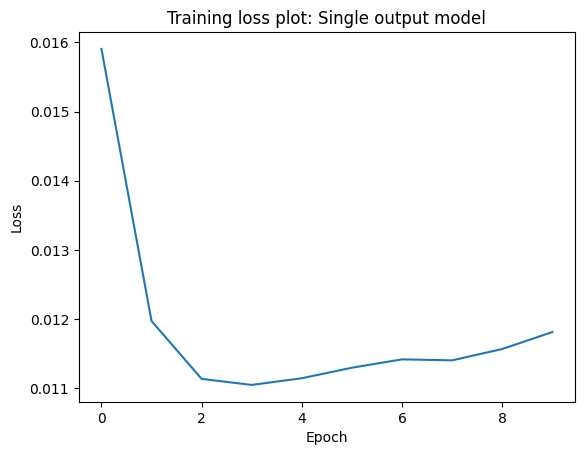

In [19]:
import matplotlib.pyplot as plt

# Visualize the loss as the network trained
# Should be a downward trend
plt.plot(loss_graph)
plt.title("Training loss plot: Single output model")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.savefig("../loss_plots/single_output_loss.png")

### Test how the model predicts new data

The predictions of the model are compared to a random guessing and a constant guessing model

In [20]:
predictions = []
real_values = []

for x, y in zip(x_test, y_test):
    # Predict for white and black
    out = lstm_model(x[0], train=False)[0] # [0] to get rid of hidden states
    predictions.append(out[0].item() * max_elo)
    real_values.append(y[0].item() * max_elo)

    out = lstm_model(x[1], train=False)[0]
    
    predictions.append(out[0].item() * max_elo) # [0].item() to get rid of batch dimension and get the elo prediction
    real_values.append(y[1].item() * max_elo)

In [21]:
differenes = [abs(p - r) for p, r in zip(predictions, real_values)]
sorted_differences = sorted(differenes)

nintieth_percentile = int(len(sorted_differences) * 0.90)
diff = round(sorted_differences[nintieth_percentile], 2)
print(f"90% of the predictions are within {diff} elo points of the real value")

90% of the predictions are within 522.84 elo points of the real value


Correlation coefficient: 0.794930477951148


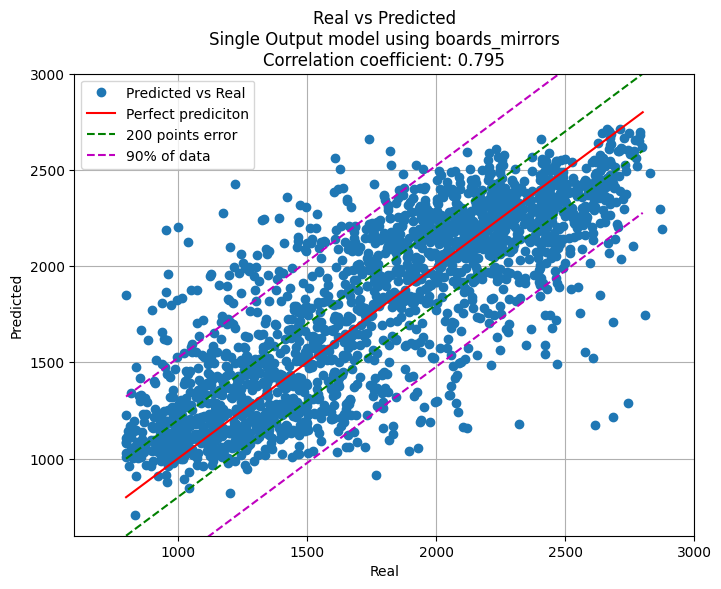

In [24]:
fig = plt.figure(figsize=(8, 6))
axs = fig.add_subplot(111)


axs.plot(real_values[:2000], predictions[:2000], 'o', label="Predicted vs Real")

axs.plot([800, 2800], [800, 2800], 'r-', label="Perfect prediciton") # the closer to this line the better
axs.plot([800, 2800], [600, 2600], 'g--', label="200 points error")
axs.plot([800, 2800], [1000, 3000], 'g--', label="") # these two lines show acceptable error (200 elo)

axs.plot([800, 2800], [800 + diff, 2800 + diff], 'm--', label="90% of data")
axs.plot([800, 2800], [800 - diff, 2800 - diff], 'm--', label="") # these two lines encompas 90% of the data


from scipy.stats import pearsonr
corr_coeff, _p = pearsonr(real_values, predictions)
print(f"Correlation coefficient: {corr_coeff}")

axs.set_title(f"Real vs Predicted\nSingle Output model using {position_type}\nCorrelation coefficient: {corr_coeff:.3f}")

axs.set_xlabel("Real")
axs.set_ylabel("Predicted")

axs.set_xlim(600, 3000)
axs.set_ylim(600, 3000)

axs.grid()
axs.legend()

# fig.savefig(f"../loss_plots/rating_ranges_{position_type}_predictions.png")
plt.show()

In [27]:
def rate_predictions(predictions, real_values):
    correct = 0
    diff = 0
    high_elo = [0, 0]
    low_elo = [0, 0]
    real_high = 0
    real_low = 0
    # We give the model a leeway of +-200 points
    # More leeway = more accuracy
    leeway = 200
    for prediction, real in zip(predictions, real_values):
        if real - leeway <= prediction <= real + leeway:
            correct += 1
        diff += abs(prediction - real)
        if real > 1700:
            high_elo[0] += 1
            high_elo[1] += prediction
            real_high += real
        if real <= 1700:
            low_elo[0] += 1
            low_elo[1] += prediction
            real_low += real
    return correct / len(predictions), correct, diff/len(predictions), high_elo[1]/high_elo[0], low_elo[1]/low_elo[0], real_high/high_elo[0], real_low/low_elo[0]

percentage, correct, diff, high_predictions, low_predictions, real_high, real_low = rate_predictions(predictions, real_values)
print(f"Correctly predicted {percentage * 100:.2f}% of games")
print(f"{correct} out of {len(predictions)} predictions")
print(f"Average difference: {diff:.2f} elo")
print(f"Average prediction for high elo games: {high_predictions:.2f} elo. Real average: {real_high:.2f} elo")
print(f"Average prediction for low elo games: {low_predictions:.2f} elo. Real average: {real_low:.2f} elo")

Correctly predicted 50.62% of games
3037 out of 6000 predictions
Average difference: 247.07 elo
Average prediction for high elo games: 2103.41 elo. Real average: 2177.81 elo
Average prediction for low elo games: 1420.32 elo. Real average: 1279.51 elo


In [29]:
import random

random_predictions = [random.randint(800, 3000) for _ in range(len(predictions))]
percentage, correct, diff, _, _, _, _ = rate_predictions(random_predictions, real_values)
print(f"Correctly guessed at random {percentage * 100:.2f}% of games")
print(f"{correct} out of {len(random_predictions)} predictions")  
print(f"Average difference: {diff:.2f} elo") 

Correctly guessed at random 18.02% of games
1081 out of 6000 predictions
Average difference: 678.22 elo


In [31]:
constant_predictions = [(800 + 2800)//2 for _ in range(len(predictions))]
percentage, correct, diff, _, _, _, _  = rate_predictions(constant_predictions, real_values)
print(f"Correctly guessed with constant guess {percentage * 100:.2f}% of games")
print(f"{correct} out of {len(constant_predictions)} predictions")
print(f"Average difference: {diff:.2f} elo")

Correctly guessed with constant guess 22.35% of games
1341 out of 6000 predictions
Average difference: 447.70 elo


In [23]:
# If the results are acceptable, save the model
torch.save(lstm_model.state_dict(), f"{position_type}.pt")